In [1]:
import os
os.chdir(os.path.abspath(".."))

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from dataio import load_metadataset, load_rmses
from metamodel import build_baseline, build_regression_topline

from sklearn.feature_selection import SelectFpr, VarianceThreshold
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score

In [23]:
for feature_set in ["catch22", "minimal", "efficient", "comprehensive"]:
    print(f"--- Analysing {feature_set} features ---")
    meta_X, meta_y = load_metadataset(feature_set, problem_type="regression")
    total_features = meta_X.shape[1]

    variance_selector = VarianceThreshold((1e-5)**2).fit(meta_X)
    meta_X_threshold = meta_X[variance_selector.get_feature_names_out()]
    threshold_features = meta_X_threshold.shape[1]

    removed_features = total_features - threshold_features
    print(f"{removed_features} feature(s) removed due to low variance ({100 * removed_features / total_features:.2f}%)")

    anova_selector = SelectFpr(alpha=0.05).fit(meta_X_threshold, meta_y)
    meta_X_final = meta_X_threshold[anova_selector.get_feature_names_out()]
    final_features = meta_X_final.shape[1]

    print(f"{final_features} out of {threshold_features} features are significant ({(100 * final_features / threshold_features):.2f}%)")

    print("Best ranked features:")
    for n, i in enumerate(np.argsort(anova_selector.pvalues_)[:10]):
        print(f"\t{n+1}. {meta_X_threshold.columns[i]}: {100 - 100 * anova_selector.pvalues_[i]:.5f}% confidence")

    print("")
    


--- Analysing catch22 features ---
0 feature(s) removed due to low variance (0.00%)
12 out of 57 features are significant (21.05%)
Best ranked features:
	1. mean_CO_trev_1_num: 100.00000% confidence
	2. std_CO_trev_1_num: 99.99962% confidence
	3. mean_SP_Summaries_welch_rect_centroid: 99.99424% confidence
	4. number_examples: 99.98344% confidence
	5. mean_SB_TransitionMatrix_3ac_sumdiagcov: 99.93712% confidence
	6. std_PD_PeriodicityWang_th0_01: 99.67928% confidence
	7. mean_SB_MotifThree_quantile_hh: 99.55269% confidence
	8. mean_SP_Summaries_welch_rect_area_5_1: 98.80426% confidence
	9. mean_FC_LocalSimple_mean3_stderr: 97.98173% confidence
	10. mean_MD_hrv_classic_pnn40: 97.76195% confidence

--- Analysing minimal features ---
1 feature(s) removed due to low variance (3.57%)
1 out of 27 features are significant (3.70%)
Best ranked features:
	1. number_examples: 99.98344% confidence
	2. mean_length: 94.45016% confidence
	3. label_median: 22.07641% confidence
	4. mean_sum_values: 21.0

In [24]:
print("--- Analysing label features ---")
meta_X, meta_y = load_metadataset("minimal", problem_type="regression")
label_columns = [c for c in meta_X.columns if c.startswith("label_")]
meta_X = meta_X[label_columns]

anova_selector = SelectFpr(alpha=0.05).fit(meta_X, meta_y)
for n, i in enumerate(np.argsort(anova_selector.pvalues_)):
    print(f"{n+1}. {meta_X.columns[i]}: {100 - 100 * anova_selector.pvalues_[i]:.5f}% confidence")


--- Analysing label features ---
1. label_median: 22.07641% confidence
2. label_minimum: 16.13110% confidence
3. label_mean: 11.91450% confidence
4. label_maximum: 7.71725% confidence
5. label_standard_deviation: 7.28307% confidence
6. label_root_mean_square: 3.53245% confidence


In [39]:
print("--- Best estimator accuracies ---")

for feature_set in ["catch22", "minimal", "efficient", "comprehensive"]:
    results = pd.read_csv(f"./results/regression_label_{feature_set}_xgb.csv")
    acc = accuracy_score(results["best_estimator"], results["predicted_estimator"])
    
    print(f"{feature_set}: {100 * acc:.5f}%")

--- Best estimator accuracies ---
catch22: 35.48387%
minimal: 40.32258%
efficient: 35.48387%
comprehensive: 33.87097%


In [57]:
results = dict()
rmses = load_rmses()
for feature_set in ["catch22", "minimal", "efficient", "comprehensive"]:
    res = pd.read_csv(f"results/regression_label_{feature_set}_xgb.csv")
    results[feature_set] = res["rmse"]

results["datasets"] = res["dataset"]
results["baseline"] = build_baseline(rmses)
results["topline"] = build_regression_topline(rmses)

results = pd.DataFrame(results).set_index("datasets")
results_normalized = ((results.T - results.T.mean()) / results.T.std()).T
results_normalized

,catch22,minimal,efficient,comprehensive,baseline,topline
datasets,,,,,,
AcousticContaminationMadrid-no-missing,0.059007,-1.227003,0.908967,0.908967,0.577065,-1.227003
AluminiumConcentration,0.164468,0.164468,0.164468,0.164468,1.200018,-1.857891
AppliancesEnergy,-0.452707,1.850365,-0.452707,-0.452707,0.402016,-0.894261
BIDMC32HR,-0.408248,-0.408248,-0.408248,-0.408248,2.041241,-0.408248
BIDMC32RR,-0.400738,-0.400738,-0.400738,-0.400738,2.041014,-0.438063
...,...,...,...,...,...,...
TetuanEnergyConsumption,-0.383112,-0.383112,-0.383112,-0.383112,2.038761,-0.506314
VentilatorPressure,0.051723,0.051723,0.051723,0.051723,1.472608,-1.679501
WaveDataTension,-0.446618,-0.297051,0.715183,0.715183,0.970719,-1.657415


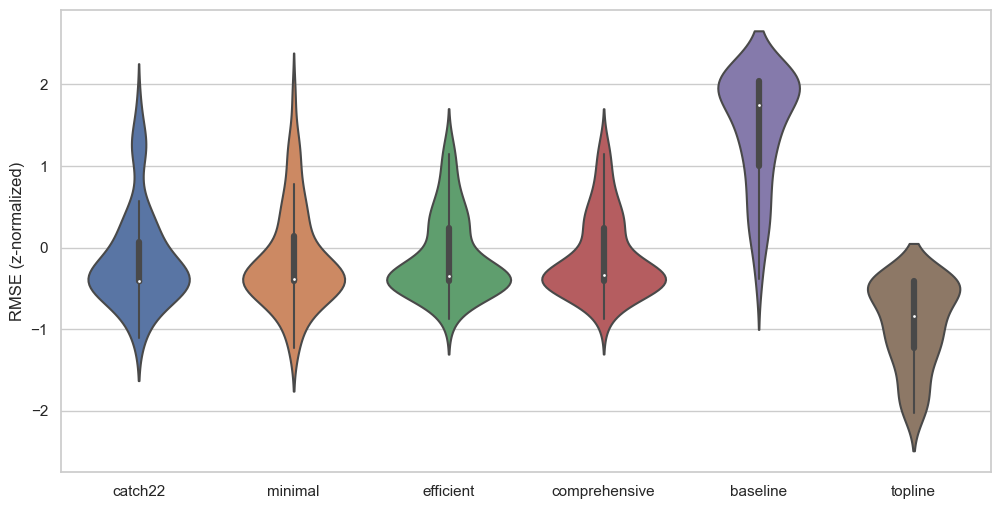

In [58]:
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(12,6))

sns.violinplot(data=results_normalized, ax=ax)
ax.set_xlabel("")
ax.set_ylabel("RMSE (z-normalized)")

plt.show()